In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [31]:
#To reload functions - Keep in mind !
reload(IF)

<module 'Important_Functions' from '/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks/Important_Functions.py'>

## Importing data

In [2]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Getting GTIs

In [3]:
new_gti = IF.get_GTIs(Time_phase_file[2])

## Getting the event arrival times taking into account the orbital correction

In [4]:
#Setting up the parameters used by the Stingray documentation to correct the event arrival times
correct_orbital_time = IF.get_orbital_correction(Time_phase_file[1], 'orbit_t2.txt')

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2022-10-17 18:52:11.619 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2022-10-17 18:52:11.620 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2022-10-17 18:52:11.620 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2022-10-17 18:52:11.688 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2022-10-17 18:52:11.695 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2022-10-17 18:52:12.579 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2022-10-17 18:52:12.605 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

In [5]:
correct_list, guess_freq = IF.get_pulse_freq(0.208, 0.209, 1000, correct_orbital_time, new_gti, 20000)

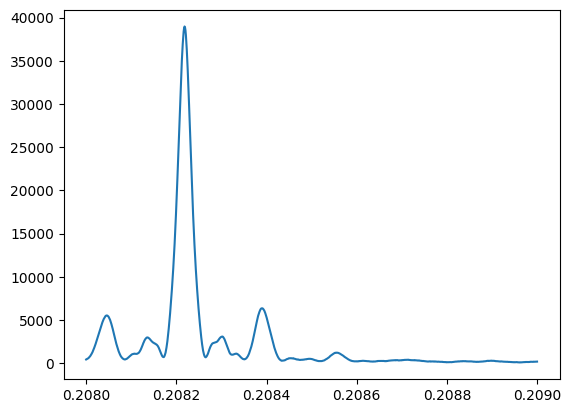

In [6]:
#Plotting the power as a function energy
plt.plot(correct_list[0], correct_list[1])
plt.show()

# Getting the pulse profile matrix with orbitally corrected time segments

## Segmenting data

In [7]:
reload(IF)
number_segments = 30
time_seg, PI_seg = IF.segment_time(Time_phase_data['PI'], correct_orbital_time, number_segments)

## Get the periodogram for the segments

In [8]:
freq_seg, power_seg = IF.get_power_and_freq(time_seg, PI_seg, number_segments)

## Getting the first harmonic frequencies and regression coefficients

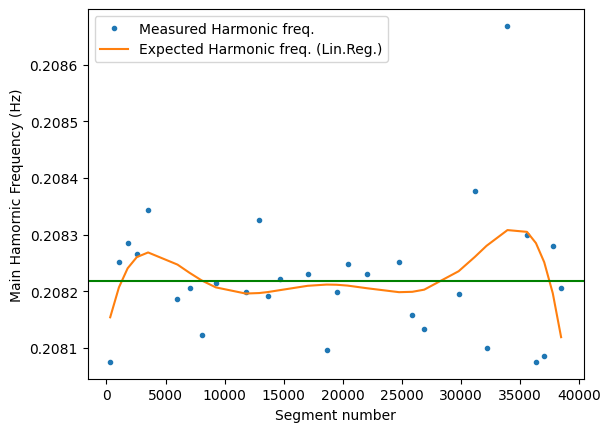

In [9]:
reload(IF)
reg, bins = IF.Harmonic_funk(6, 0.01, Time_phase_data['TIME'][0], time_seg, freq_seg, power_seg, guess_freq)

## Getting the pulse profile matrix

16
11
7
7
4
13
9
12
9
5
6
2
9
3
5
11
9
11
4
5
9
9
6
6
10
7
6
6
6
6


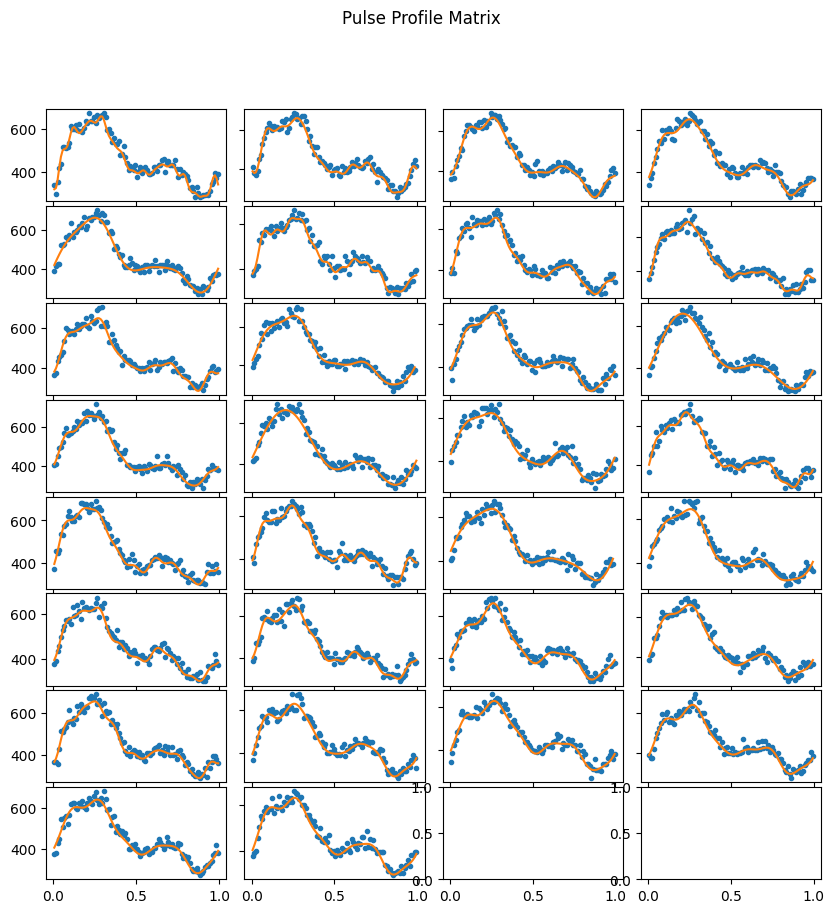

In [10]:
reload(IF)
orders, model_phases, counts, phasefolded_time = IF.pulse_profile_matrix(time_seg, Time_phase_data['TIME'][0], [guess_freq])



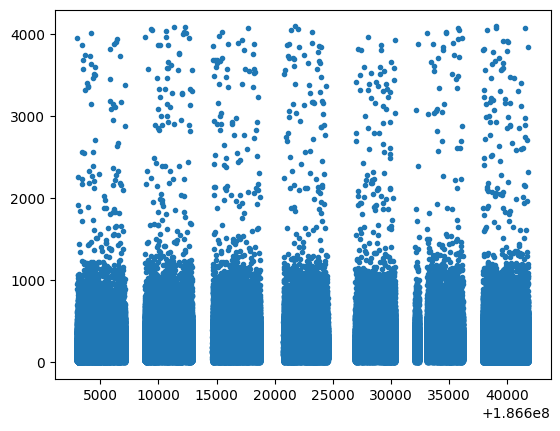

In [11]:
plt.plot(Time_phase_data['TIME'], Time_phase_data['PI'], '.')

# Getting the ENERGY pulse profile matrix

In [108]:
reload(IF)
energy_time_segments, energy_segments = IF.segment_energywise(correct_orbital_time, 
                                                              Time_phase_data['PI'], 120, 2800, -50)



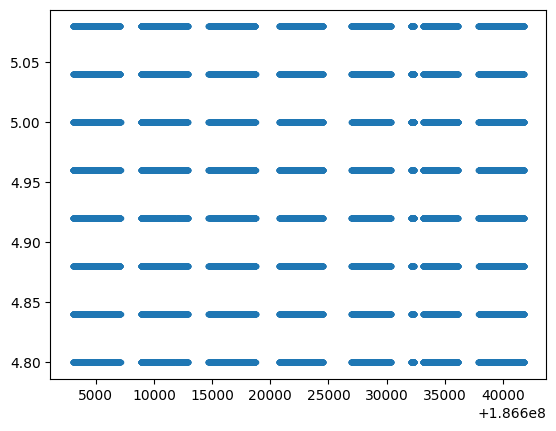

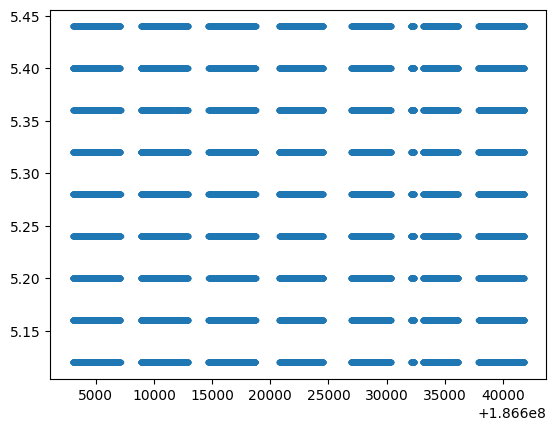

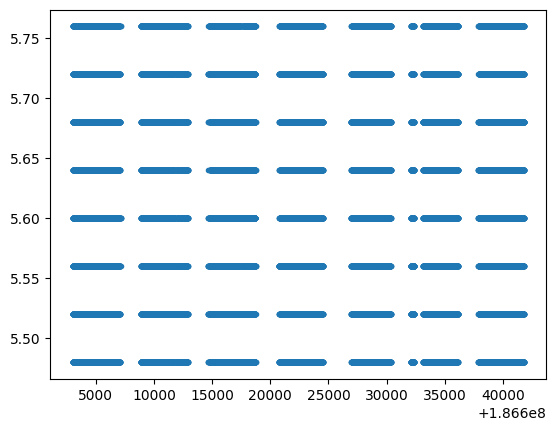

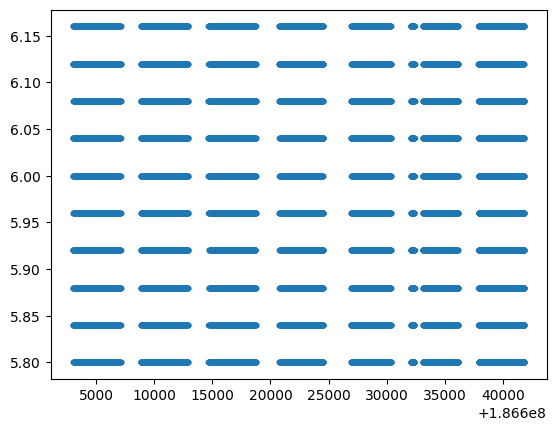

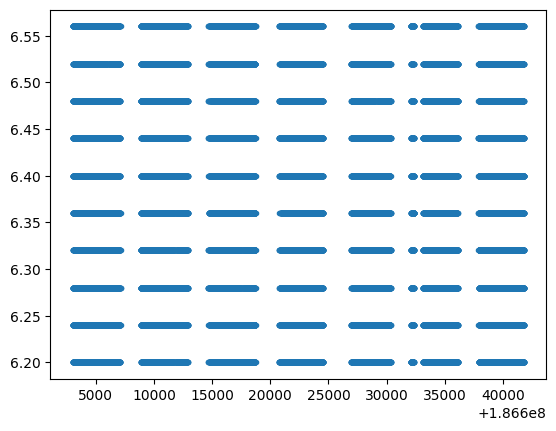

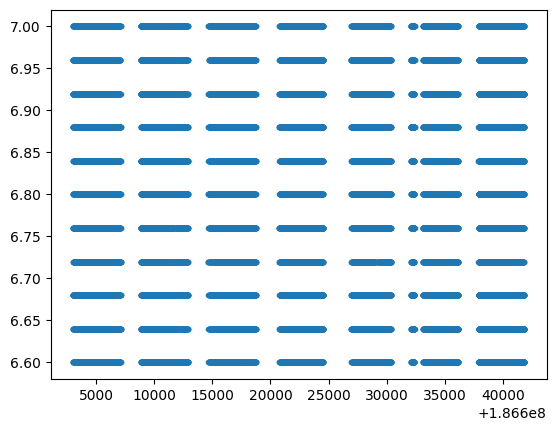

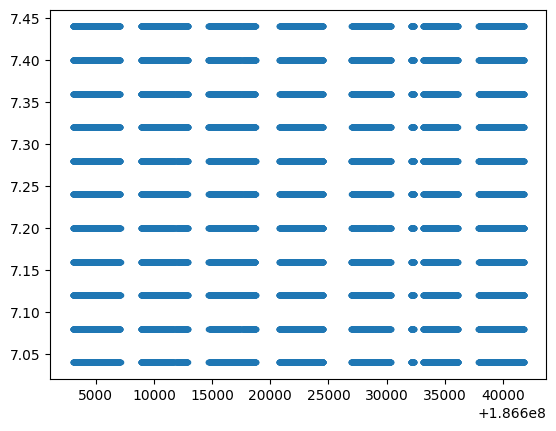

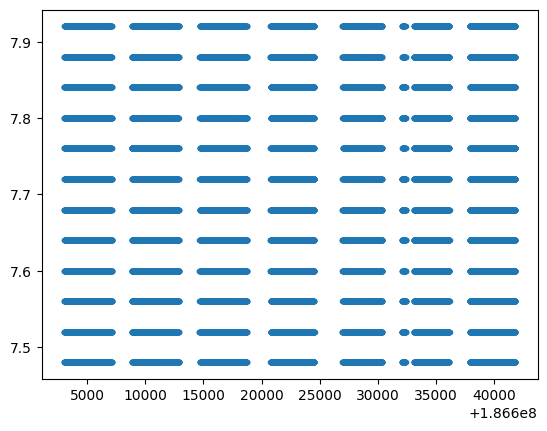

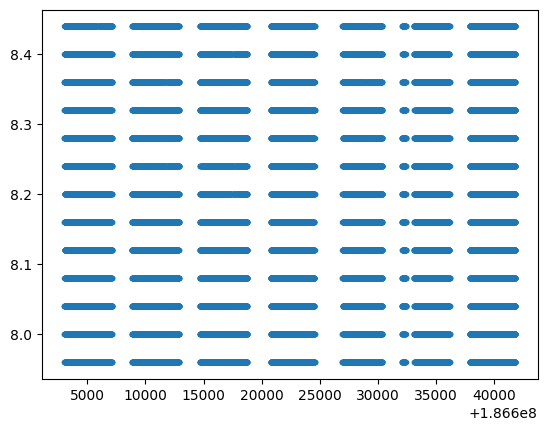

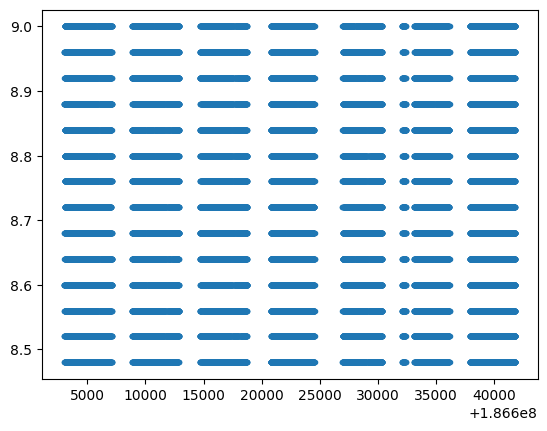

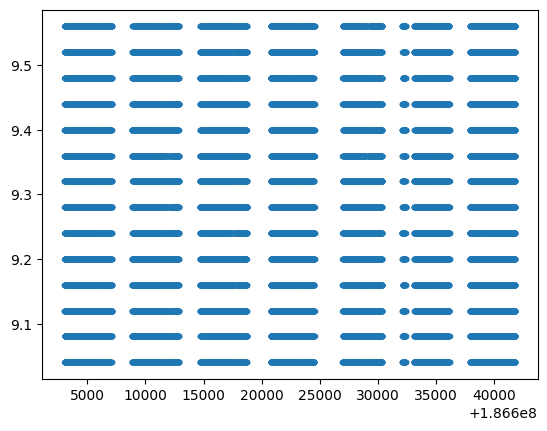

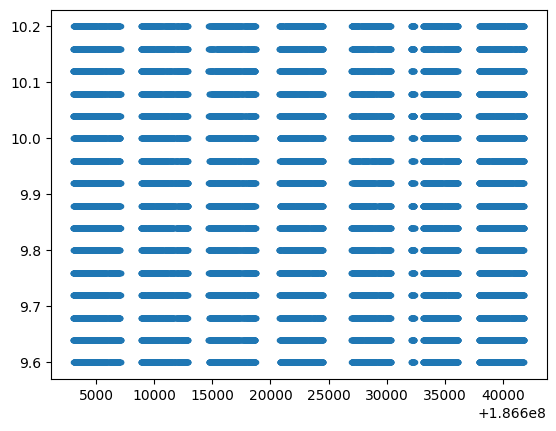

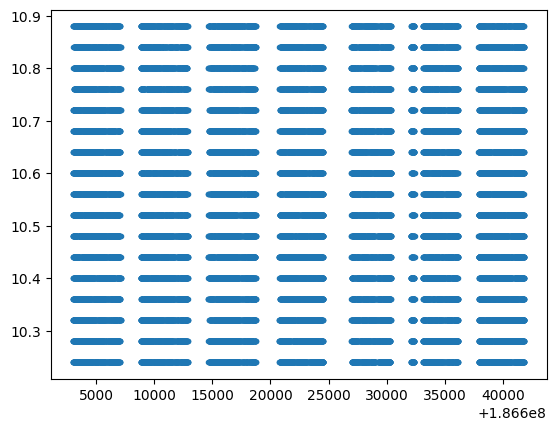

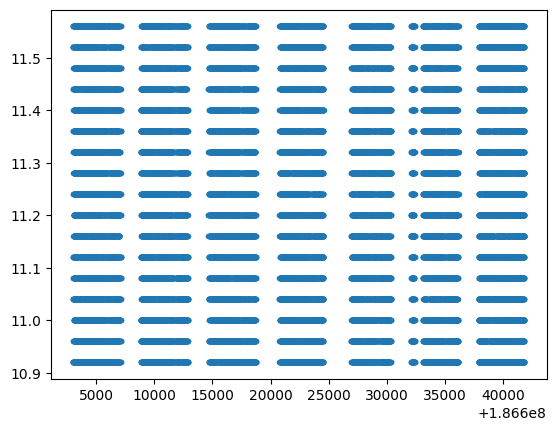

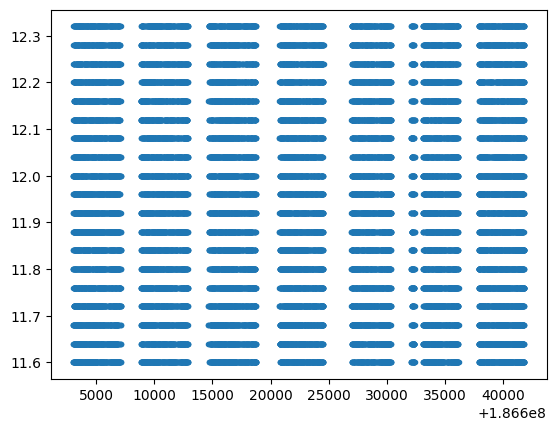

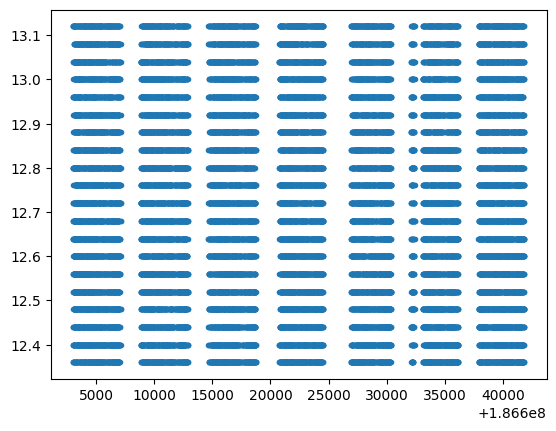

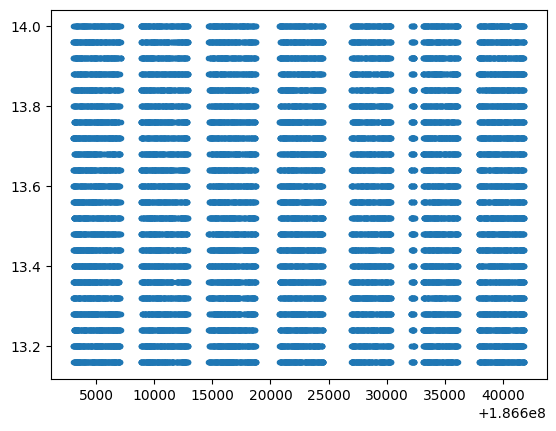

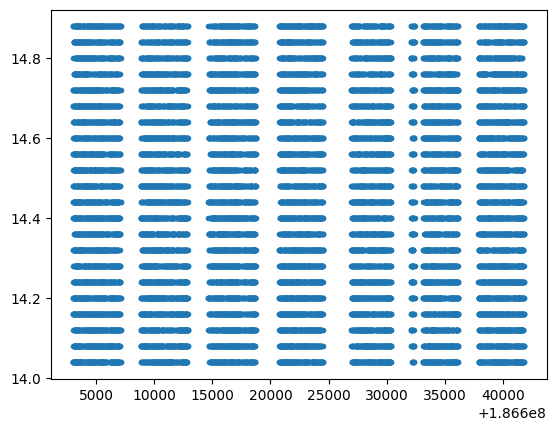

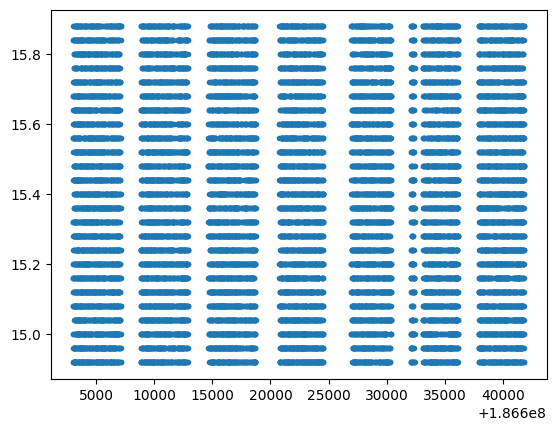

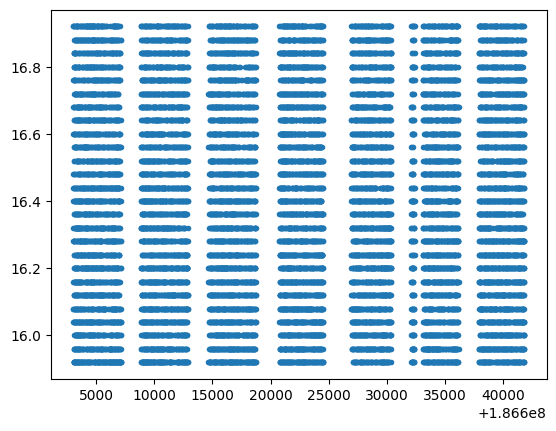

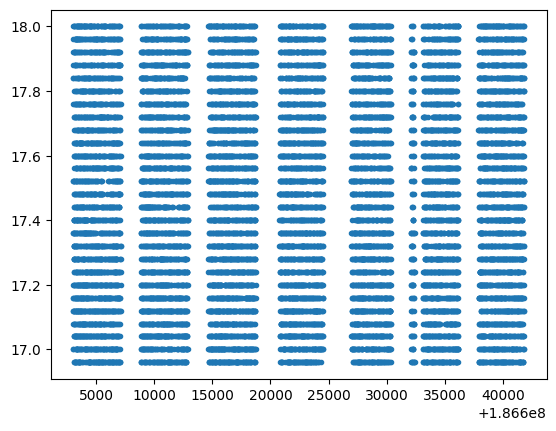

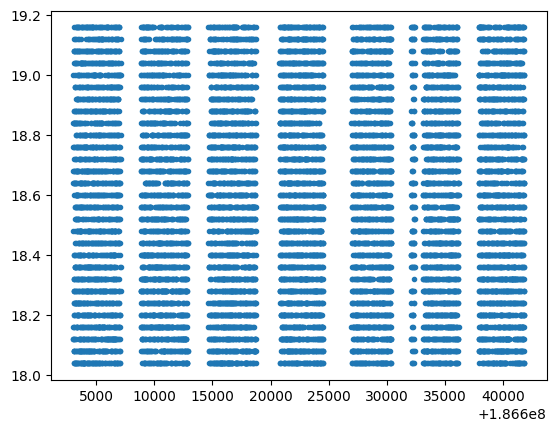

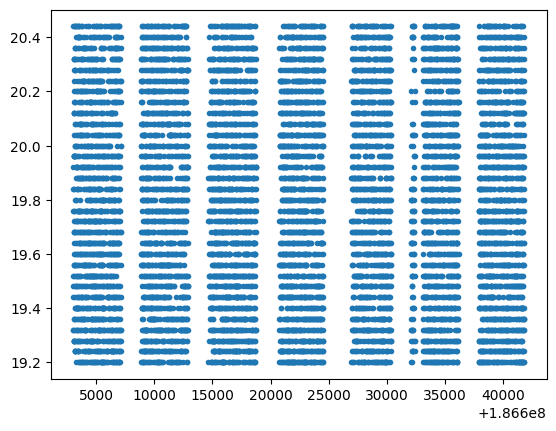

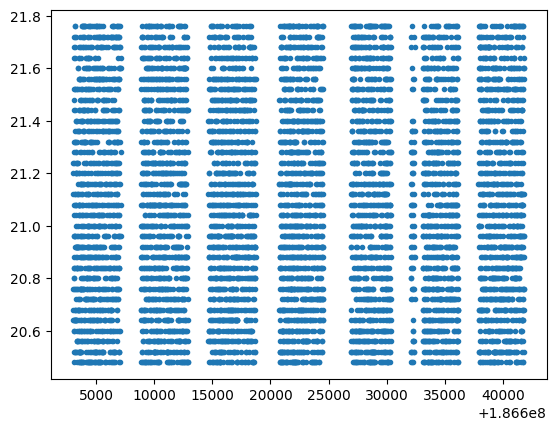

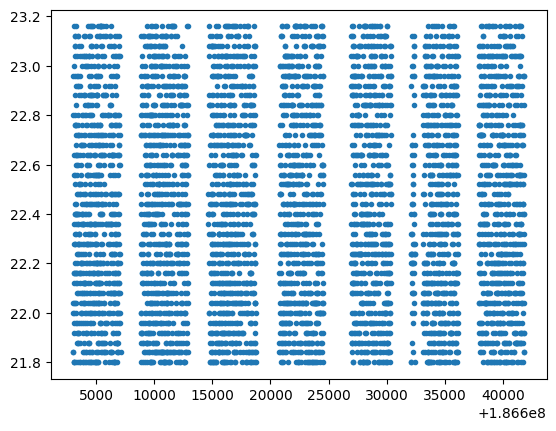

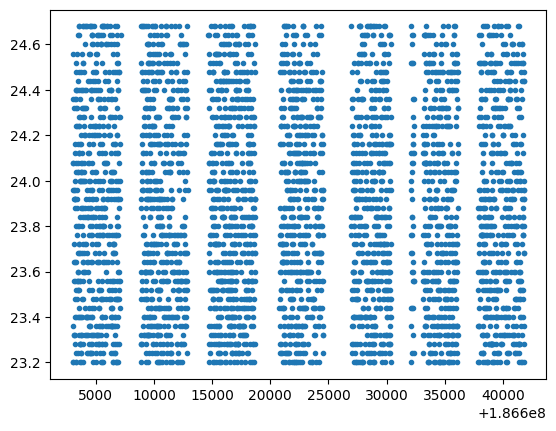

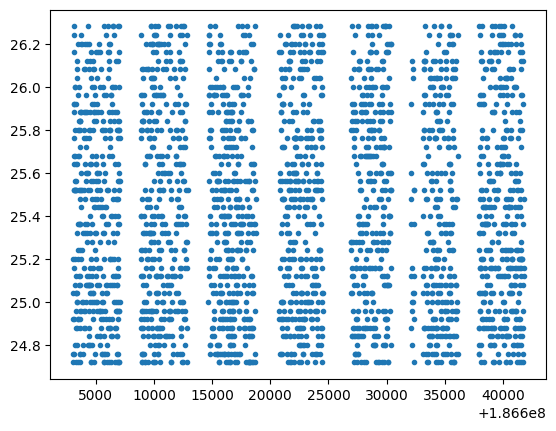

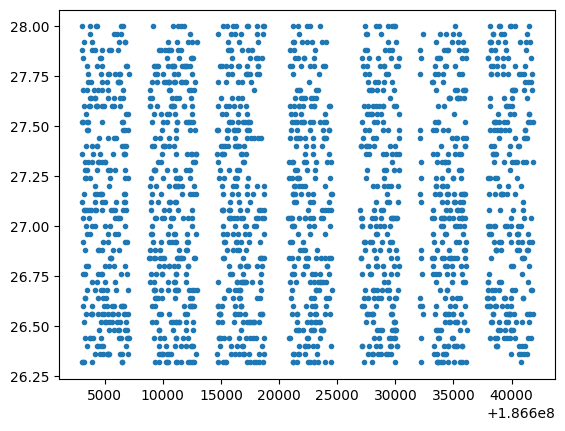

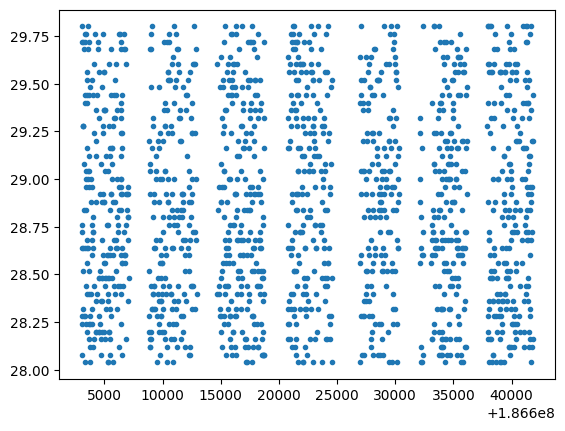

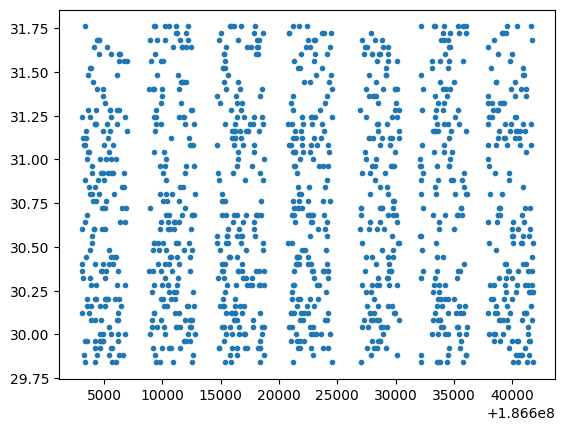

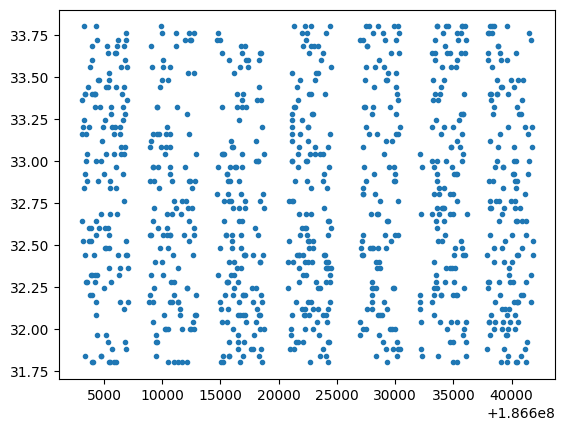

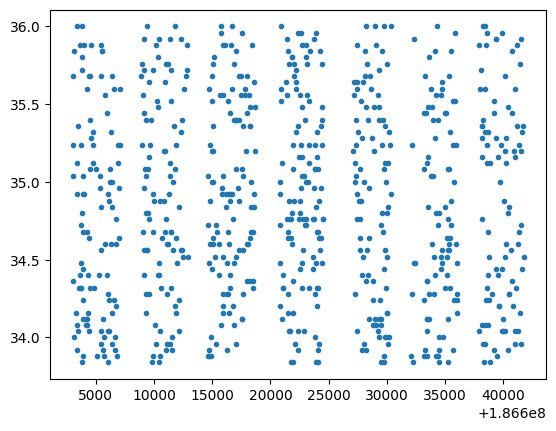

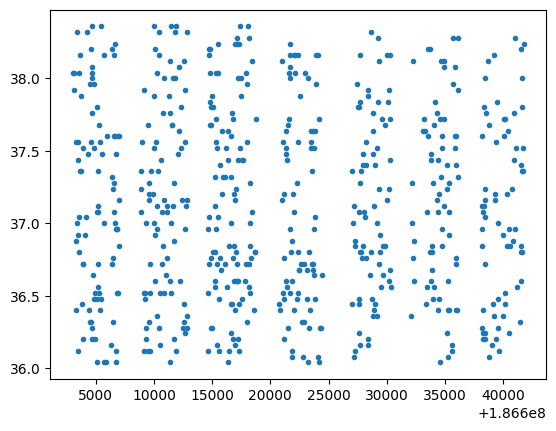

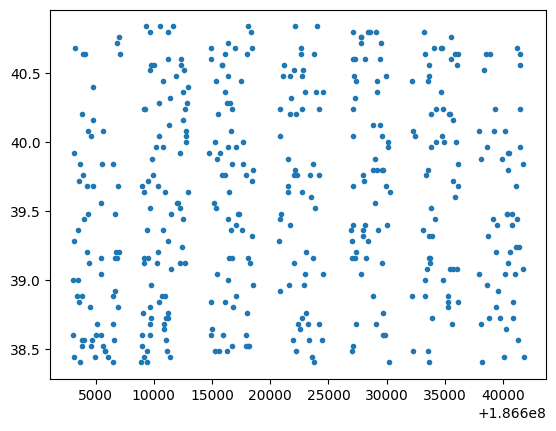

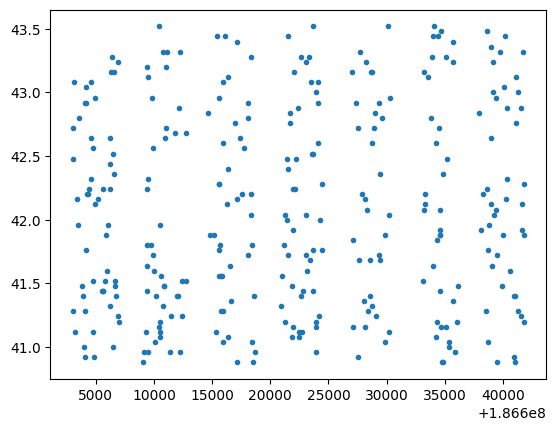

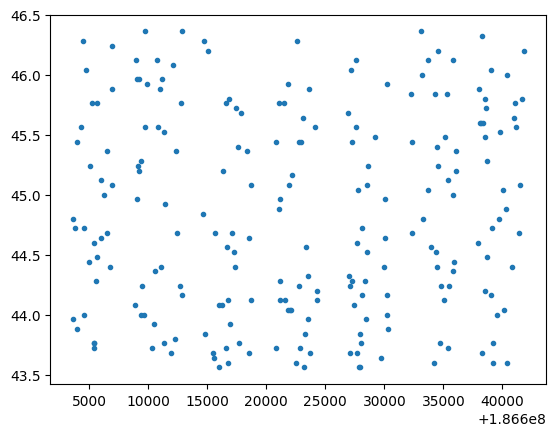

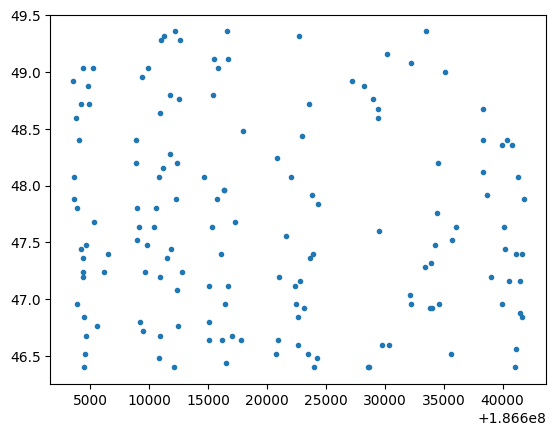

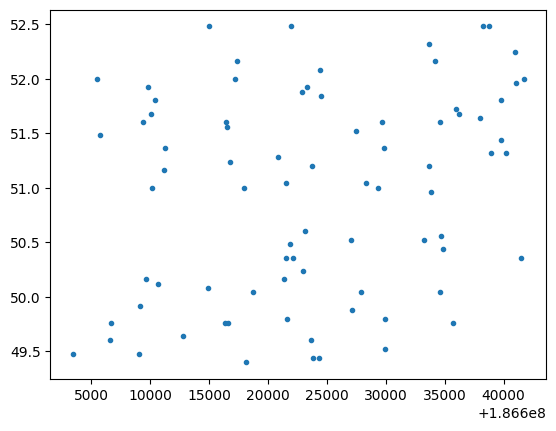

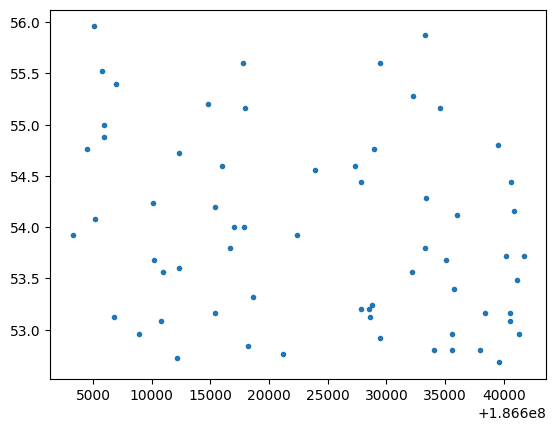

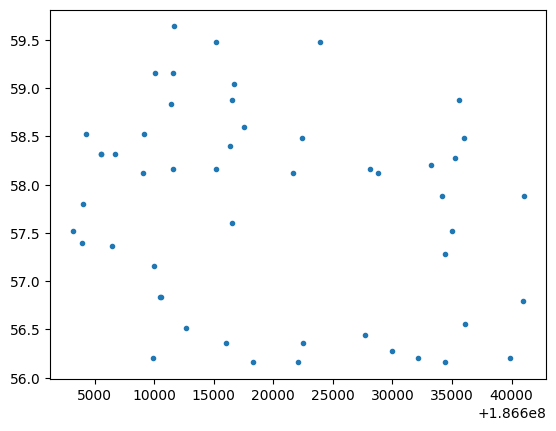

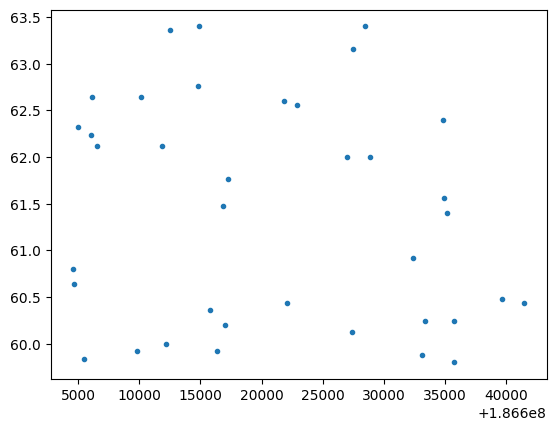

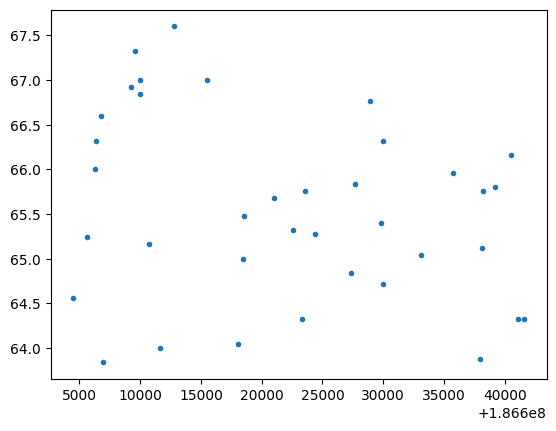

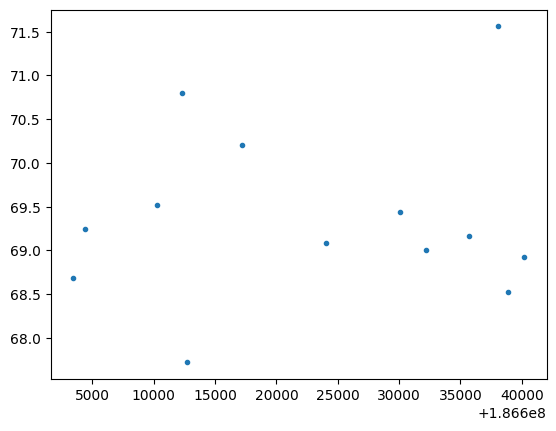

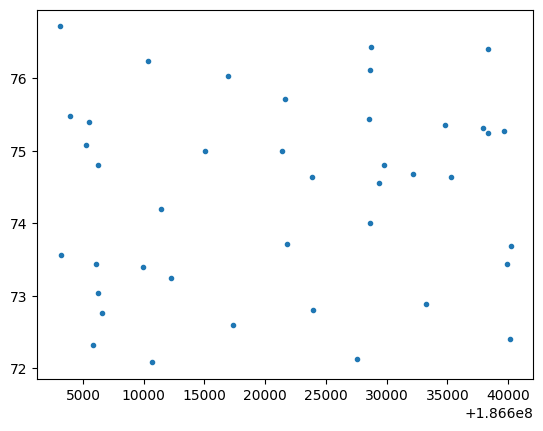

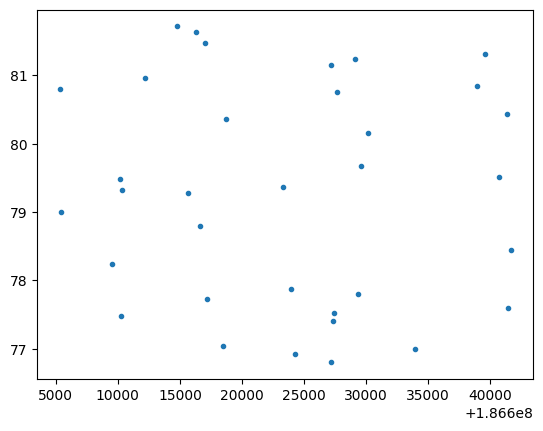

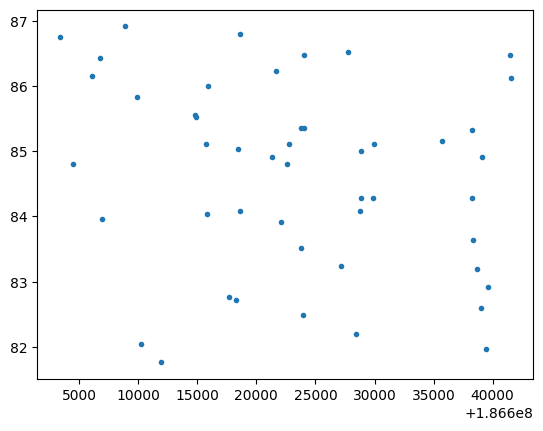

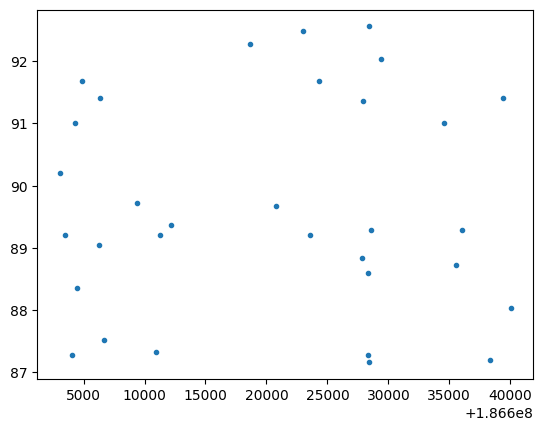

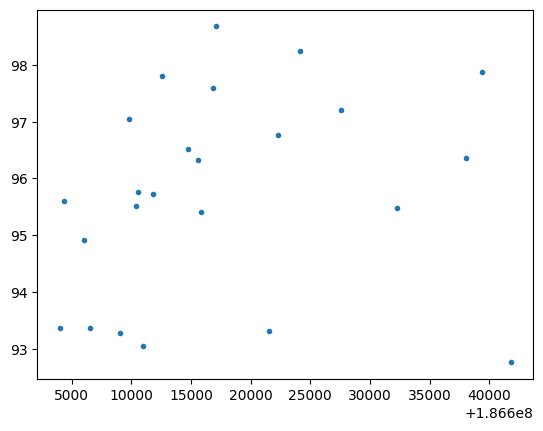

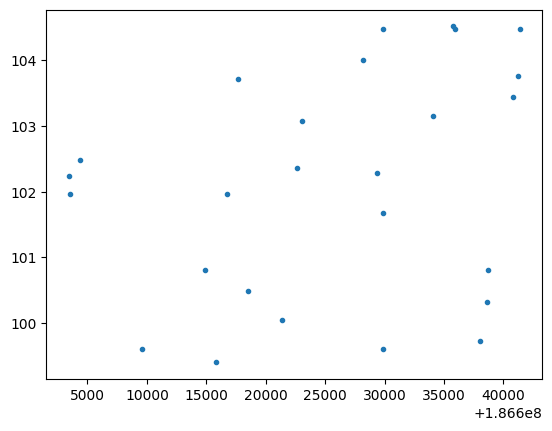

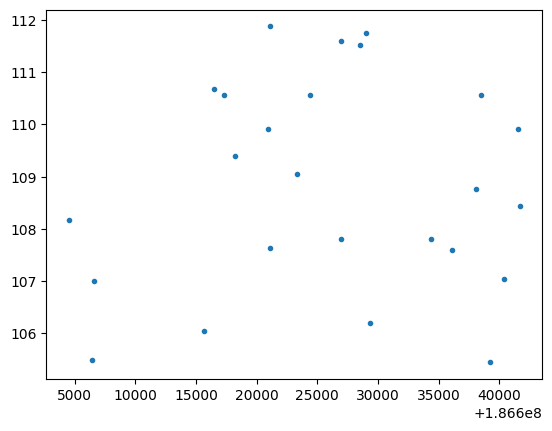

In [109]:
for i in range(50):
    plt.plot(energy_time_segments[i], energy_segments[i], '.')
    plt.show()

## Plotting the energy pulse profile matrix 

32
11
11
13
8
13
14
15
9
10
10
10
10
12
10
9
9
9
9
7
22
6
5
7
9
4
30
3
23
3
28
24
28


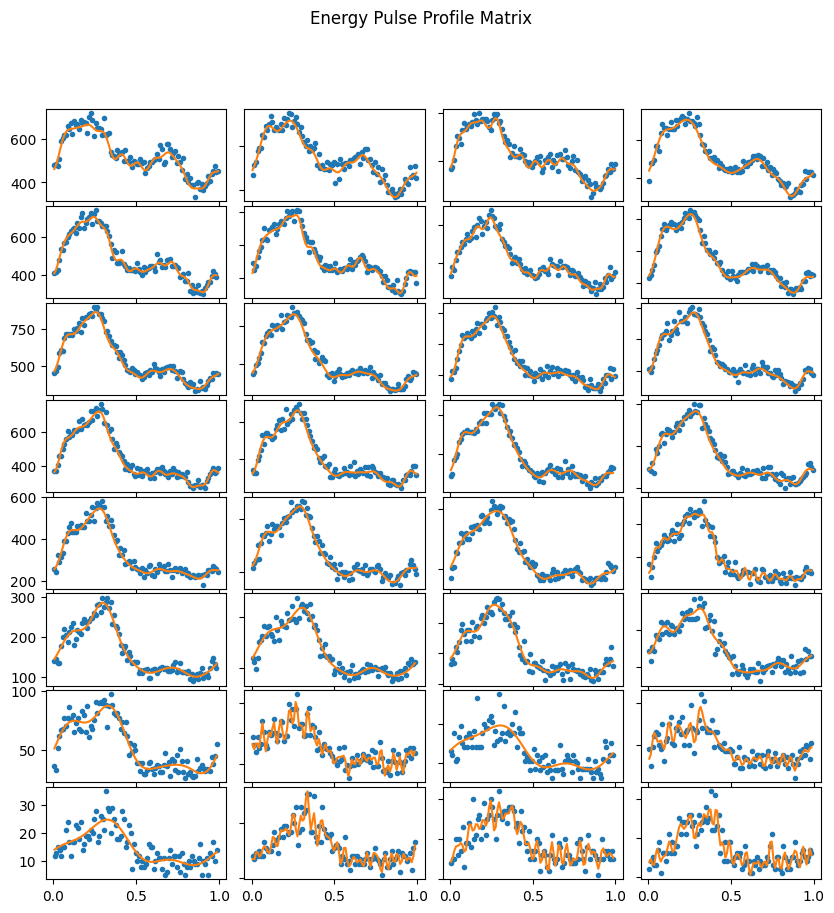

In [111]:
reload(IF)

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, 
                                                                                                 Time_phase_data['TIME'][0], 
                                                                                                 [guess_freq], True, 32, 0.01, 0.3)



In [112]:
print(len(energy_orders))

32


## Using bootstrap method to find the uncertainty on the phase 

## Re-making the bootstrapping method to be more general and calculating the phase and RMS for each energy pulse profile (i.e. making sure the new functions work)

In [116]:
reload(IF)
RMS_error = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    print('RMS is:',IF.RMS_calculator(energy_counts[i], energy_orders[i]), ' +/- ', RMS_error[i])
    print('First phase is:', IF.get_first_harmonic_phase(energy_counts[i]), ' +/- ', IF.bootstrap_total(energy_counts[i], 100, IF.get_first_harmonic_phase)) 
    print('\n')

RMS is: 0.1201468462643478  +/-  9.342383623525341e-06
First phase is: -1.5863463948719023  +/-  0.0011490513263821471


RMS is: 0.12824873582640373  +/-  8.695280552693375e-06
First phase is: -1.5625872393408606  +/-  0.0006744090521242324


RMS is: 0.14847495593057988  +/-  1.1450309907505039e-05
First phase is: -1.5519923669411106  +/-  0.0006253108562236588


RMS is: 0.16390325746865564  +/-  1.1394884021207075e-05
First phase is: -1.534374564122854  +/-  0.0004931862219062168


RMS is: 0.1719328444594232  +/-  1.1110480806406753e-05
First phase is: -1.5594097960206845  +/-  0.00038783780774042124


RMS is: 0.18080174406331084  +/-  8.736223405284658e-06
First phase is: -1.5459915854846682  +/-  0.00040341441160645047


RMS is: 0.18751303445250098  +/-  1.0672716764536853e-05
First phase is: -1.5031826046536598  +/-  0.0004075947109153531


RMS is: 0.1916163446140341  +/-  1.0357782264605525e-05
First phase is: -1.4805929570142689  +/-  0.00025721169716918336


RMS is: 0.2032312606

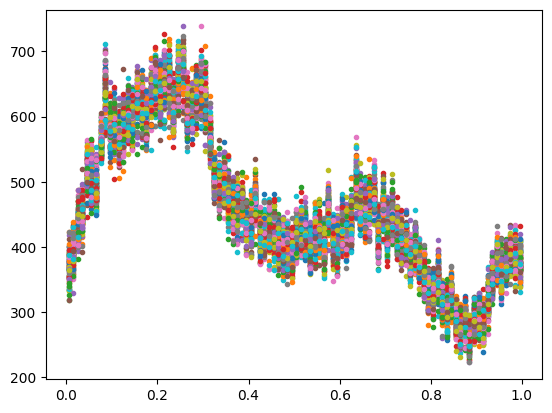

In [84]:
for i in range(100):
    plt.plot(energy_phasefold_time[3], IF.bootstrap_generate(energy_counts[3], 100)[i], '.')
plt.show()

## Plotting the RMS against energy 

Text(0.5, 1.0, 'Plot of the RMS against Energy')

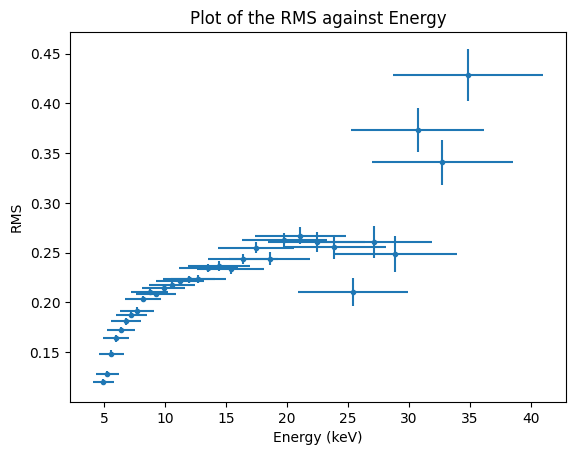

In [140]:
reload(IF)
RMSs = np.zeros(len(energy_counts))
avg = np.zeros(len(energy_counts))
RMS_error = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    RMSs[i] = IF.RMS_calculator(energy_counts[i], energy_orders[i])
    avg[i] = np.mean(energy_segments[i])

avg_error = np.array(avg)/np.sqrt(len(energy_counts))
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=avg_error, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy')
#plt.savefig('/Users/samsonmercier/Desktop/RMS_vs_Energy.pdf')